In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french-text-classification/act_couv.csv


**In this jupyter notebook, we will see how to train the Distilbert model to classify French text.
Since our data are imbalanced, we will train our model with two different data:**
*  the first data is downsampled
*  the second one is oversampled

**At the end we will choose the best model and use it for Inference mode**

## Import all packages

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
!pip install transformers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

## Reading and Cleaning the Dataset

In [3]:
# read data
data = pd.read_csv('../input/french-text-classification/act_couv.csv', sep=';')
data.head()

,description,class
0,entreprises de menuiserie fabricant de porte p...,False
1,cheminees accessoires specialiste du fer forg...,False
2,bricolage outillage reproduction de cle robin...,False
3,vente pose de revetements de sols et de murs ...,False
4,vente installation de chauffage vente inst...,True


In [4]:
# change the target value to 1 for True and 0 for False
data.loc[data['class'] == True, 'class'] = 1
data.loc[data['class'] == False, 'class'] = 0
data.head()

,description,class
0,entreprises de menuiserie fabricant de porte p...,0
1,cheminees accessoires specialiste du fer forg...,0
2,bricolage outillage reproduction de cle robin...,0
3,vente pose de revetements de sols et de murs ...,0
4,vente installation de chauffage vente inst...,1


In [5]:
# shape
print("The dataset has {} rows and {} columns.".format(*data.shape))

# sum of duplicates
print("It contains {} duplicates.".format(data.duplicated().sum()))

The dataset has 6663 rows and 2 columns.
It contains 3256 duplicates.


In [6]:
data = data.drop_duplicates()
# verification
print("It contains {} duplicates.".format(data.duplicated().sum()))

It contains 0 duplicates.


## Target Variable

In [7]:
target_count = data["class"].value_counts()
target_count

0    2827
1     580
Name: class, dtype: int64

In [8]:
target_ratio = [v/sum(target_count)*100 for v in target_count]
print('target Ratio: ', target_ratio)
True_ratio = target_count[1]/sum(target_count)*100
print('True calss ratio: {0}%'.format(True_ratio))

target Ratio:  [82.97622541825653, 17.02377458174347]
True calss ratio: 17.02377458174347%


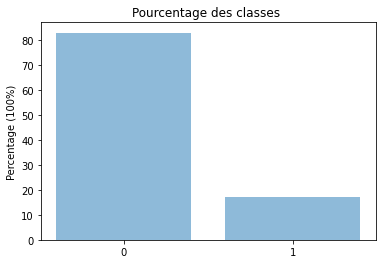

In [9]:
y_pos = range(len(target_count))
plt.bar(y_pos,target_ratio,align='center', alpha=.5)
plt.xticks(y_pos,target_count.index)
plt.ylabel('Percentage (100%)')
plt.title('Pourcentage des classes ')
plt.show()

We see clearly that our data is imbalanced, To balance our data we can use one of this methods:

* downsampling
* oversampling

# Downsamling

In [10]:
# split our data
df_class1 = data[data['class']==1]
df_class1.shape

(580, 2)

In [11]:
df_class0 = data[data['class']==0]
df_class0.shape

(2827, 2)

In [12]:
df_class0_downsampled = df_class0.sample(df_class1.shape[0])
df_class0_downsampled.shape

(580, 2)

In [13]:
# concatenate the balanced data 
df_balanced = pd.concat([df_class0_downsampled, df_class1])
df_balanced.shape

(1160, 2)

In [14]:
df_balanced['class'].value_counts()

0    580
1    580
Name: class, dtype: int64

## Shuffling the dataset

In [15]:
df_balanced = shuffle(df_balanced)
df_balanced.head()

,description,class
797,entreprises de couverture traitement de toitur...,1
4672,entreprises de couverture travaux de couvertur...,1
5844,entreprises de desamiantage travaux de couvert...,1
2242,vente installation de chauffage depannage de ...,0
4245,fenetres pose de verandas portails garages i...,0


## Loading DistilBERT Tokenizer and the DistilBERT model

In [16]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf

### Preparing input for the model

In [17]:
max_len=32
num_classes=len(df_balanced['class'].unique())
sentences=data['description']
labels=data['class']
len(sentences),len(labels)

(3407, 3407)

### Create a basic NN model using DistilBERT

In [18]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model   

In [19]:
model=create_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

### Prepare the model input

In [20]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
labels = np.array(labels)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
len(input_ids),len(attention_masks),len(labels)

(3407, 3407, 3407)

### Save the model input in the pickle files to use it later without performing the above steps

In [22]:
print('Preparing the pickle file.....')

pickle_inp_path='./dbert_inp.pkl'
pickle_mask_path='./dbert_mask.pkl'
pickle_label_path='./dbert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./dbert_inp.pkl ./dbert_mask.pkl ./dbert_label.pkl


### Loading the saved pickle files

In [23]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (3407, 32) Attention mask shape (3407, 32) Input label shape (3407,)


In [24]:
label_class_dict={0:False, 1:True}
target_names=label_class_dict.values()
target_names

dict_values([False, True])

### Train Test split and setting up the loss function, accuracy and optimizer for the model.

In [25]:
# split data 
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)
print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (2725, 32) Val input shape (682, 32)
Train label shape (2725,) Val label shape (682,)
Train attention mask shape (2725, 32) Val attention mask shape (682, 32)


In [26]:
# setting up the loss function, accuracy and optimizer for the model.
log_dir='dbert_model'
model_save_path='./dbert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [27]:
# callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
# model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

## Training

In [28]:
# transforming target values to numpy arrays
train_label = np.array([np.array(val) for val in train_label])
val_label = np.array([np.array(val) for val in val_label])
# train
history=model.fit([train_inp,train_mask],train_label,batch_size=164,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


17/17 [==============================] - 16s 489ms/step - loss: 6.5879 - accuracy: 0.8106 - val_loss: 6.3860 - val_accuracy: 0.8607
Epoch 2/10
17/17 [==============================] - 5s 324ms/step - loss: 6.3583 - accuracy: 0.8591 - val_loss: 6.1852 - val_accuracy: 0.9120
Epoch 3/10
17/17 [==============================] - 6s 326ms/step - loss: 6.1520 - accuracy: 0.9035 - val_loss: 6.0662 - val_accuracy: 0.9120
Epoch 4/10
17/17 [==============================] - 5s 314ms/step - loss: 6.0225 - accuracy: 0.9079 - val_loss: 5.9589 - val_accuracy: 0.9135
Epoch 5/10
17/17 [==============================] - 6s 326ms/step - loss: 5.8956 - accuracy: 0.9101 - val_loss: 5.8658 - val_accuracy: 0.9120
Epoch 6/10
17/17 [==============================] - 6s 329ms/step - loss: 5.7837 - accuracy: 0.9130 - val_loss: 5.7680 - val_accuracy: 0.8974
Epoch 7/10
17/17 [==============================] - 5s 314ms/step - loss: 5.6550 - accuracy: 0.9178 - val_loss: 5.6569 - val_accuracy: 0.9223
Epoch 8/10
17/17

### Use the saved model for predictions and calculating the evaluation metrics

In [29]:
trained_model = create_model()
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model[1][0] 

In [30]:
# get predictions
preds = trained_model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
f1

0.6404494382022472

In [31]:
target_names = ['False','True']
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))

F1 score 0.6404494382022472
Classification Report
              precision    recall  f1-score   support

       False       0.94      0.96      0.95       587
        True       0.69      0.60      0.64        95

    accuracy                           0.91       682
   macro avg       0.81      0.78      0.79       682
weighted avg       0.90      0.91      0.90       682



*   the f1 score is low, thus we can say that the model doesn't perform well on our data.
*   by looking at the classification report, we conclude that our model performs well in the class 0 ('False')


### plot confusion matrix

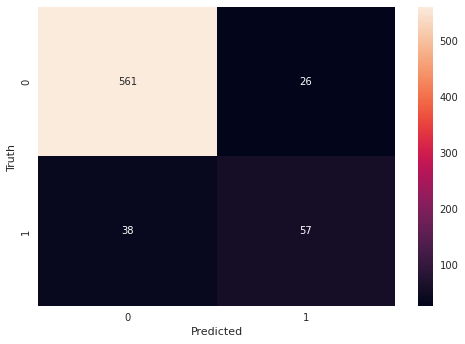

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

cm = confusion_matrix(val_label,pred_labels)
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



*   The confusion matrix confirms our interpretation about the class 1 


# Oversampling

### Now we will train the model using oversampling technique and we will discuss the results 

In [33]:
# to oversample our minority class
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler 

In [34]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [35]:
# fit and apply the transform
labels_ = np.array([np.array(v) for v in data['class']])
X_res, y_res = oversample.fit_resample(data.loc[:, data.columns != 'class'], labels_)

In [36]:
values, counts = np.unique(y_res, return_counts=True)
values, counts

(array([0, 1]), array([2827, 2827]))

### We have oversampled the minority class

## re-train the model with oversamling

In [37]:
max_len=32
num_classes=2
sentences=X_res['description']
labels=y_res
len(sentences),len(labels)

(5654, 5654)

In [38]:
# create model
model_oversamling=create_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_distil_bert_model[2][0] 

### Prepare the model input

In [39]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [40]:
print('Preparing the pickle file.....')

pickle_inp_path='./dbert_inp_oversampling.pkl'
pickle_mask_path='./dbert_mask_oversampling.pkl'
pickle_label_path='./dbert_label_oversampling.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./dbert_inp_oversampling.pkl ./dbert_mask_oversampling.pkl ./dbert_label_oversampling.pkl


In [41]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))


Loading the saved pickle files..
Input shape (5654, 32) Attention mask shape (5654, 32) Input label shape (5654,)


In [42]:
label_class_dict={0:False, 1:True}
target_names=label_class_dict.values()
target_names

dict_values([False, True])

### Split data

In [43]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)
print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


Train inp shape (4523, 32) Val input shape (1131, 32)
Train label shape (4523,) Val label shape (1131,)
Train attention mask shape (4523, 32) Val attention mask shape (1131, 32)


### Setting up the loss function, accuracy and optimizer for the model.

In [44]:
log_dir='dbert_model'
model_save_path='./dbert_model_oversampling.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model_oversamling.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [45]:
# train the model
history=model_oversamling.fit([train_inp,train_mask],train_label,batch_size=164,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


28/28 [==============================] - 20s 459ms/step - loss: 6.4570 - accuracy: 0.8530 - val_loss: 6.2676 - val_accuracy: 0.9195
Epoch 2/10
28/28 [==============================] - 9s 336ms/step - loss: 6.1692 - accuracy: 0.9262 - val_loss: 6.0577 - val_accuracy: 0.9443
Epoch 3/10
28/28 [==============================] - 9s 335ms/step - loss: 5.9533 - accuracy: 0.9476 - val_loss: 5.8829 - val_accuracy: 0.9540
Epoch 4/10
28/28 [==============================] - 9s 314ms/step - loss: 5.7631 - accuracy: 0.9571 - val_loss: 5.6974 - val_accuracy: 0.9567
Epoch 5/10
28/28 [==============================] - 9s 315ms/step - loss: 5.6006 - accuracy: 0.9578 - val_loss: 5.5512 - val_accuracy: 0.9461
Epoch 6/10
28/28 [==============================] - 9s 313ms/step - loss: 5.4137 - accuracy: 0.9684 - val_loss: 5.4102 - val_accuracy: 0.9452
Epoch 7/10
28/28 [==============================] - 9s 335ms/step - loss: 5.2475 - accuracy: 0.9735 - val_loss: 5.2280 - val_accuracy: 0.9531
Epoch 8/10
28/28

In [46]:
# load best checkpoint
trained_model = create_model()
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 768)          0           tf_distil_bert_model[3][0] 

### Get predictions and calculate f1 score

In [47]:
preds = trained_model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
f1

0.9502948609941029

In [48]:
target_names=['False','True']
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))

F1 score 0.9502948609941029
Classification Report
              precision    recall  f1-score   support

       False       0.99      0.90      0.95       563
        True       0.91      0.99      0.95       568

    accuracy                           0.95      1131
   macro avg       0.95      0.95      0.95      1131
weighted avg       0.95      0.95      0.95      1131



### Confusion matrix

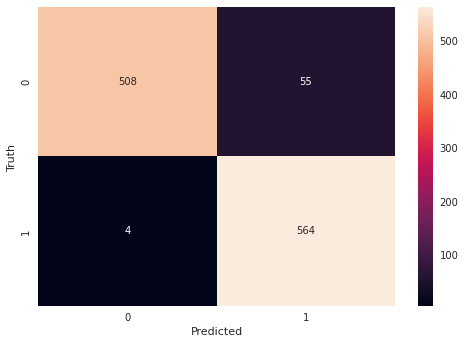

In [49]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

cm = confusion_matrix(val_label,pred_labels)
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


*   We see that the f1 score is now higher than the previous one.
*   Results are good for both classes
*   We conclude that the use of oversampling in our case gives accurate results
*   By comparing the Bert model with DistilBERT, we can say that for our data, DistilBERT is working well so far





# Inference

In [50]:
def prepareInput(sentences, dbert_tokenizer) :
    max_len = 32
    input_ids=[]
    attention_masks=[]

    for sent in sentences:
        dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    
    return input_ids, attention_masks

In [51]:
def getPrediction(model, sentences, dbert_tokenizer):
    # prepare Input
    input_ids, attention_masks = prepareInput(sentences = sentences, dbert_tokenizer = tokenizer)
    # start prediction
    preds = trained_model.predict([input_ids,attention_masks],batch_size=2)
    pred = preds.argmax(axis=1)[0]
    return pred == 1

In [52]:
# loadthe dbert_tokenizer
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# load the model
# model parameters
model_save_path='./dbert_model_oversampling.h5'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
# creat and load weights
trained_model = create_model()
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 768)          0           tf_distil_bert_model[4][0] 

## let's predict the first sentence which belong to the calss 0 ('False')

In [53]:
data.head()

,description,class
0,entreprises de menuiserie fabricant de porte p...,0
1,cheminees accessoires specialiste du fer forg...,0
2,bricolage outillage reproduction de cle robin...,0
3,vente pose de revetements de sols et de murs ...,0
4,vente installation de chauffage vente inst...,1


In [54]:
sentences = [data['description'].iloc[0]]
print(sentences)
tokenizer = dbert_tokenizer
print("\nprediction ... ")
getPrediction(model = trained_model, sentences = sentences, dbert_tokenizer = tokenizer)

['entreprises de menuiserie fabricant de porte produits portail aluminium porte d entree porte d entree en aluminium porte de garage portes d entree alu  entreprises de menuiserie portes de garage portes  portails magasins de meubles ']

prediction ... 


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


False

## let's predict the fifth sentence which belong to the calss 1 ('True')

In [55]:
sentences = [data['description'].iloc[4]]
print(sentences)
tokenizer = dbert_tokenizer
print("\nprediction ... ")
getPrediction(model = trained_model, sentences = sentences, dbert_tokenizer = tokenizer)

['vente  installation de chauffage   vente  installation de chauffage installation de sanitaires entreprises de couverture ']

prediction ... 


True